In [1]:
import sys 
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [1]:
pip show numpy

Name: numpy
Version: 1.23.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: c:\users\gkg99\anaconda3\lib\site-packages
Requires: 
Required-by: astropy, bkcharts, bokeh, Bottleneck, fst-pso, FuzzyTM, gensim, h5py, imagecodecs, imageio, imbalanced-learn, jax, matplotlib, miniful, mkl-fft, mkl-random, ml-dtypes, numba, numexpr, opt-einsum, pandas, patsy, pyerfa, pyFUME, pyLDAvis, PyWavelets, scikit-image, scikit-learn, scipy, seaborn, simpful, statsmodels, tables, tensorboard, tensorflow-intel, tifffile
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

  Using cached numpy-1.23.5-cp38-cp38-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] 拒绝访问。: 'C:\\Users\\gkg99\\anaconda3\\Lib\\site-packages\\~.mpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



In [2]:
import numpy
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, pad_sequences
from keras.callbacks import EarlyStopping


In [3]:
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt

import string
import util
import io
import os
from pprint import pprint
import pickle
import re

import warnings
warnings.filterwarnings(action='once')
#warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


%matplotlib inline

import seaborn as sns



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, pad_sequences
from keras.callbacks import EarlyStopping


import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# import gensim
# import gensim.corpora as corpora
# from gensim.corpora import Dictionary
# from gensim.models.coherencemodel import CoherenceModel
# from gensim.models.ldamodel import LdaModel

# import pyLDAvis
# import pyLDAvis.gensim_models
# import matplotlib.pyplot as plt
# import matplotlib
# %matplotlib inline
# import pandas as pd
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn import metrics
# from sklearn.decomposition import LatentDirichletAllocation


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gkg99\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gkg99\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gkg99\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gkg99\AppData\Roaming\nltk_data...


True

In [4]:
# Count number of rows with each label without considering combination
comments = pd.read_csv("train.csv")
#comments.iloc[:, 2:].sum(axis=0)

df_multilabel = comments

# convert into binary
comments['harmful'] = comments.iloc[:, 2:].sum(axis=1)
comments['harmful'][comments['harmful']>0] = 1

# keep necessary info
df = comments[['comment_text',"harmful"]]#.copy()

print(df['harmful'].value_counts())
df.head()


0    143346
1     16225
Name: harmful, dtype: int64


<ipython-input-4-0352fd8fba14>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments['harmful'][comments['harmful']>0] = 1


,comment_text,harmful
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


# Data Cleaning

In [5]:
def preprocess(df):
    def remove_punctuation(text):
        #return str(text).translate(str.maketrans('', '', string.punctuation))
        text_nopunct = "".join([char for char in str(text) if char not in string.punctuation])
        return text_nopunct

    def tokenize_text(text):
        tokens = nltk.word_tokenize(text) 
        tokens = [token.strip() for token in tokens]
        return tokens

    def remove_stopwords(tokens):
        stopword_list = nltk.corpus.stopwords.words('english')
        filtered_tokens = [token for token in tokens if token not in stopword_list]
        #filtered_text = ' '.join(filtered_tokens)    
        return filtered_tokens

    def expand_contractions(text, contraction_mapping):

        contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                          flags=re.IGNORECASE|re.DOTALL)
        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            expanded_contraction = contraction_mapping.get(match)\
                                    if contraction_mapping.get(match)\
                                    else contraction_mapping.get(match.lower())                       
            expanded_contraction = first_char+expanded_contraction[1:]
            return expanded_contraction

        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
        return expanded_text
    def remove_digit(text):
        text_nodigit = re.sub(r'\w*\d\w*', '',text).strip()
        return text_nodigit

    def stemming(text):
        ps = nltk.PorterStemmer()
        return " ".join([ps.stem(word) for word in text.split()])

    def lemmatize(text):
        wn = nltk.WordNetLemmatizer()
        return " ".join([wn.lemmatize(word) for word in text.split()])
    # expand_contractions -> remove_punctuation -> remove_digit -> tokenize_text -> remove_stopwords
    
    df["comment_text_clean"] = df["comment_text"].apply(lambda x: expand_contractions(x.lower(), util.contraction_mapping))
    df["comment_text_clean"] = df["comment_text_clean"].apply(lambda x: remove_punctuation(x))
    df["comment_text_clean"] = df["comment_text_clean"].apply(lambda x: remove_digit(x))
    #df["tokenized"] = df["comment_text_clean"].apply(lambda x: tokenize_text(x))
    #df['tokenized'] =  df["tokenized"].apply(lambda x: remove_stopwords(x))
    #df['stemmed'] =  df["comment_text_clean"].apply(lambda x: stemming(x))
    df['lemmatized'] =  df["comment_text_clean"].apply(lambda x: lemmatize(x))
    return df

In [6]:
df_clean = preprocess(df)
df_clean.head()

<ipython-input-5-2e3e9b7fd878>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["comment_text_clean"] = df["comment_text"].apply(lambda x: expand_contractions(x.lower(), util.contraction_mapping))
<ipython-input-5-2e3e9b7fd878>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized'] =  df["comment_text_clean"].apply(lambda x: lemmatize(x))


,comment_text,harmful,comment_text_clean,lemmatized
0,Explanation\nWhy the edits made under my usern...,0,explanation\nwhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,daww he matches this background colour i am se...,daww he match this background colour i am seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i am really not trying to edit war it ...,hey man i am really not trying to edit war it ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more\ni cannot make any real suggestions on im...,more i cannot make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir are my hero any chance you remember wh...


# LSTM

In [8]:
X = df_clean['lemmatized']
#X = df_clean['stemmed']
Y = df_clean['harmful']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)


In [9]:
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 2000
# Max number of words in each complaint.
MAX_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=MAX_LENGTH)

In [10]:
def RNN():
    inputs = Input(name='inputs',shape=[MAX_LENGTH])
    layer = Embedding(MAX_WORDS,50,input_length=MAX_LENGTH)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [11]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 50)           100000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [12]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
848/848 [==============================] - 87s 101ms/step - loss: 0.1658 - accuracy: 0.9441 - val_loss: 0.1401 - val_accuracy: 0.9528
Epoch 2/10
848/848 [==============================] - 84s 99ms/step - loss: 0.1273 - accuracy: 0.9565 - val_loss: 0.1312 - val_accuracy: 0.9540
Epoch 3/10
848/848 [==============================] - 86s 101ms/step - loss: 0.1326 - accuracy: 0.9538 - val_loss: 0.1283 - val_accuracy: 0.9560
Epoch 4/10
848/848 [==============================] - 87s 102ms/step - loss: 0.1214 - accuracy: 0.9578 - val_loss: 0.1262 - val_accuracy: 0.9570
Epoch 5/10
848/848 [==============================] - 86s 102ms/step - loss: 0.1210 - accuracy: 0.9575 - val_loss: 0.1287 - val_accuracy: 0.9568


In [13]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=MAX_LENGTH)
accr = model.evaluate(test_sequences_matrix,Y_test)


748/748 [==============================] - 10s 14ms/step - loss: 0.1279 - accuracy: 0.9567


In [14]:
predict_labels = model.predict(test_sequences_matrix)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

748/748 [==============================] - 11s 14ms/step
Test set
  Loss: 0.128
  Accuracy: 0.957


In [15]:
predict_labels

count = 0
label_binary = []

for i in predict_labels:
    count += 1
    if i > 0.5:
        label_binary.append(1)
    else:
        label_binary.append(0)
print(count)
len(label_binary)



23936


23936

## Matthew's correlation coefficient

In [16]:
# binary accuracy result

def cal_result(y_true, y_predict, plot_matrix = False):
    mcc_score =  matthews_corrcoef(y_true, y_predict)
    acc =  accuracy_score(y_true, y_predict)
    tn, fp, fn, tp  = confusion_matrix(y_true, y_predict).ravel()

    print("True Positive (TP): ", tp)
    print("True Negative (TN): ", tn)
    print("False Positive (FP): ", fp)
    print("False Negative (FN): ", fn)

    # Calculate precision
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Print the accuracy, precision, recall, and F1-score
    print("\n\nMetrics:")
    print("Accuracy: ", round(acc, 2))
    print("Precision: ", round(precision, 2))
    print("Recall: ", round(recall, 2))
    print("F1-score: ", round(f1_score, 2))
    print("Matthew's correlation coefficient-score: ", round(mcc_score, 2))
    if (plot_matrix):
        conf_matrix = confusion_matrix(y_true, y_predict)
        #
        # Print the confusion matrix using Matplotlib
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt
#print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


True Positive (TP):  1550
True Negative (TN):  21350
False Positive (FP):  142
False Negative (FN):  894


Metrics:
Accuracy:  0.96
Precision:  0.92
Recall:  0.63
F1-score:  0.75
Matthew's correlation coefficient-score:  0.74


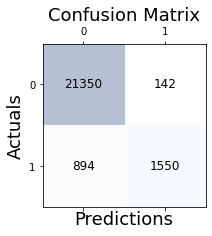

In [17]:
cal_result(Y_test, label_binary, plot_matrix = True)

# Using balanced label

In [18]:

my_path_sampled = 'pkls/data_sampled.pkl'
my_path_sampled_p = 'pkls/data_sampled_processed.pkl'

with open(my_path_sampled, "rb") as f:
    data_sampled = pickle.load(f)
with open(my_path_sampled_p, "rb") as f:
    data_sampled_p = pickle.load(f)
data_sampled_p.head()


X = data_sampled_p['remove_digit']
#X = df_clean['comment_text']
Y = data_sampled_p['harmful']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

# The maximum number of words to be used. (most frequent)
MAX_WORDS = 2000
# Max number of words in each complaint.
MAX_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=MAX_LENGTH)


FileNotFoundError: [Errno 2] No such file or directory: 'pkls/data_sampled.pkl'

In [18]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 50)           100000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [24]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
201/201 [==============================] - 21s 107ms/step - loss: 0.2230 - accuracy: 0.9147 - val_loss: 0.2322 - val_accuracy: 0.9046
Epoch 2/10
201/201 [==============================] - 21s 105ms/step - loss: 0.2156 - accuracy: 0.9160 - val_loss: 0.2346 - val_accuracy: 0.9046


In [25]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=MAX_LENGTH)
accr = model.evaluate(test_sequences_matrix,Y_test)


177/177 [==============================] - 2s 10ms/step - loss: 0.2282 - accuracy: 0.9102


In [26]:
predict_labels = model.predict(test_sequences_matrix)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

count = 0
label_binary = []

for i in predict_labels:
    count += 1
    if i > 0.5:
        label_binary.append(1)
    else:
        label_binary.append(0)
print(count)
len(label_binary)


177/177 [==============================] - 2s 10ms/step
Test set
  Loss: 0.228
  Accuracy: 0.910
5660


5660

True Positive (TP):  2170
True Negative (TN):  2982
False Positive (FP):  242
False Negative (FN):  266


Metrics:
Accuracy:  0.91
Precision:  0.9
Recall:  0.89
F1-score:  0.9
Matthew's correlation coefficient-score:  0.82


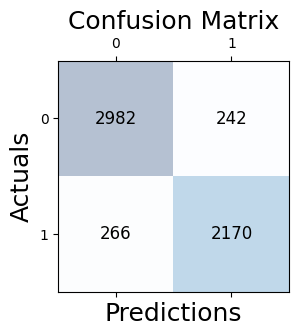

In [27]:
cal_result(Y_test, label_binary, plot_matrix = True)

748/748 [==============================] - 7s 9ms/step
Test set
  Loss: 0.191
  Accuracy: 0.925
23936
True Positive (TP):  2192
True Negative (TN):  19949
False Positive (FP):  1547
False Negative (FN):  248


Metrics:
Accuracy:  0.93
Precision:  0.59
Recall:  0.9
F1-score:  0.71
Matthew's correlation coefficient-score:  0.69


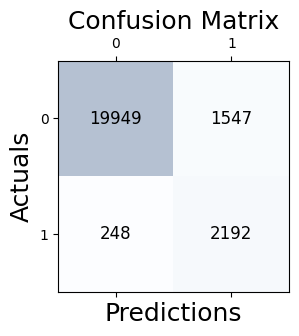

In [28]:
# fitting on original unbalanced dataset
X = df_clean['comment_text_clean']
Y = df_clean['harmful']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)


test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=MAX_LENGTH)
accr = model.evaluate(test_sequences_matrix,Y_test)

predict_labels = model.predict(test_sequences_matrix)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

count = 0
label_binary = []

for i in predict_labels:
    count += 1
    if i > 0.5:
        label_binary.append(1)
    else:
        label_binary.append(0)
print(count)
len(label_binary)

cal_result(Y_test, label_binary, plot_matrix = True)